In [85]:
with open('/home/junha/Downloads/objectinfo150.txt', 'r') as file:
    lines = file.read().splitlines()
class_name_dict = dict()
for l in lines[1:]:
    idx, ratio, train, val, fullname = l.split('\t')
    name = fullname.split(',')[0].strip()
    class_name_dict[int(idx) - 1] = name, fullname

for k, (v1, v2) in class_name_dict.items():
    print(k, v1)

0 wall
1 building
2 sky
3 floor
4 tree
5 ceiling
6 road
7 bed
8 windowpane
9 grass
10 cabinet
11 sidewalk
12 person
13 earth
14 door
15 table
16 mountain
17 plant
18 curtain
19 chair
20 car
21 water
22 painting
23 sofa
24 shelf
25 house
26 sea
27 mirror
28 rug
29 field
30 armchair
31 seat
32 fence
33 desk
34 rock
35 wardrobe
36 lamp
37 bathtub
38 railing
39 cushion
40 base
41 box
42 column
43 signboard
44 chest of drawers
45 counter
46 sand
47 sink
48 skyscraper
49 fireplace
50 refrigerator
51 grandstand
52 path
53 stairs
54 runway
55 case
56 pool table
57 pillow
58 screen door
59 stairway
60 river
61 bridge
62 bookcase
63 blind
64 coffee table
65 toilet
66 flower
67 book
68 hill
69 bench
70 countertop
71 stove
72 palm
73 kitchen island
74 computer
75 swivel chair
76 boat
77 bar
78 arcade machine
79 hovel
80 bus
81 towel
82 light
83 truck
84 tower
85 chandelier
86 awning
87 streetlight
88 booth
89 television
90 airplane
91 dirt track
92 apparel
93 pole
94 land
95 bannister
96 escalator

In [86]:
import scipy.io

colors = scipy.io.loadmat('/home/junha/Downloads/color150.mat')['colors']

In [103]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from PIL import Image
import requests
import torch
import torch.nn.functional as F
import numpy as np

feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b5-finetuned-ade-640-640")
print(feature_extractor)
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b5-finetuned-ade-640-640")
print(model)
url = "https://i.ibb.co/pzvr7nR/010335.jpg"
# image = Image.open(requests.get(url, stream=True).raw)
image = Image.open('/home/junha/data/sunrefer/rgb/000001.jpg')
inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)

SegformerFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "SegformerFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "reduce_labels": true,
  "resample": 2,
  "size": 640
}

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))

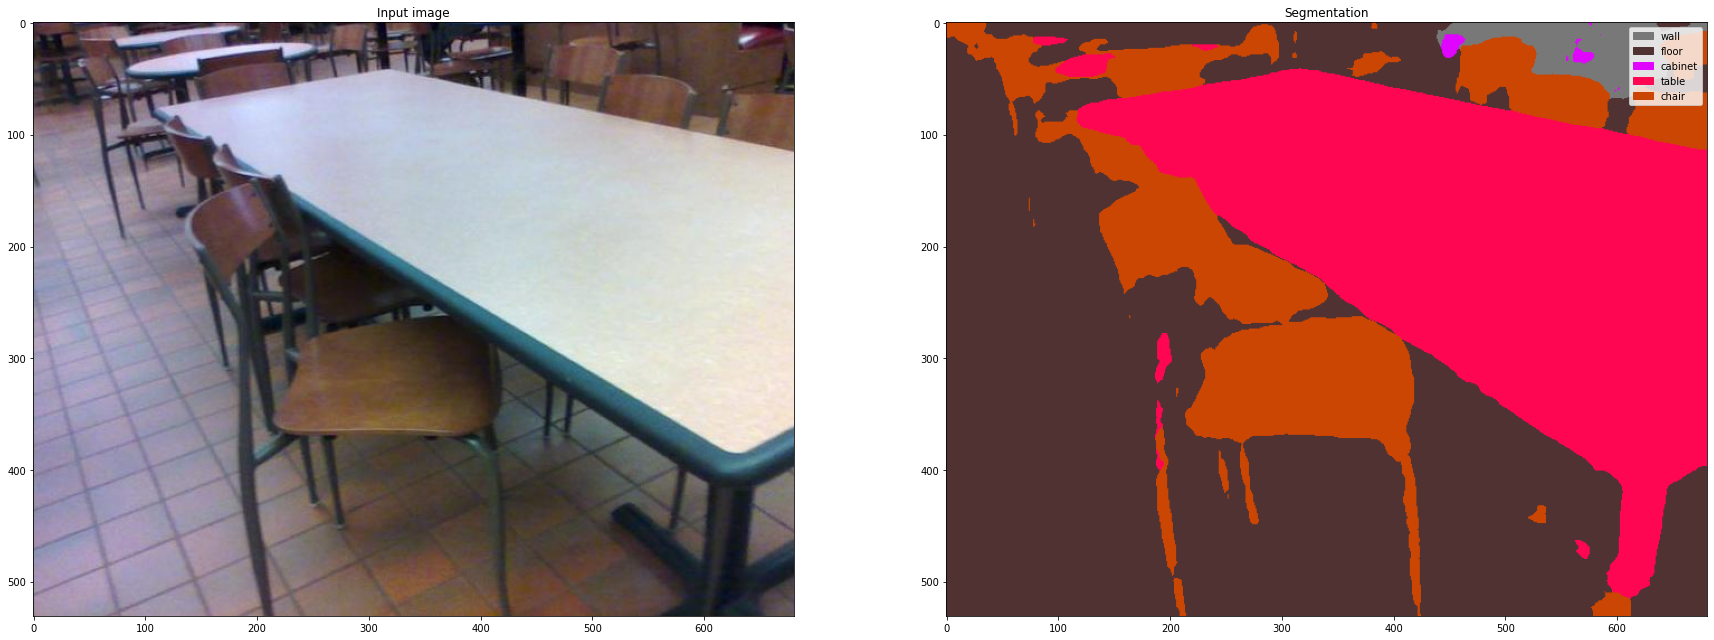

In [100]:
visualize_seg_output(image, outputs)

In [75]:
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from torchvision import transforms
import cv2


class SunreferDataset(Dataset):
    def __init__(self, root_dir: Path):
        self.root_dir = root_dir
        self.image_file_list = sorted(self.root_dir.glob('*.jpg'))

    def __getitem__(self, item):
        image = np.squeeze(cv2.imread(str(self.image_file_list[item]), cv2.IMREAD_COLOR))
        return transforms.ToTensor()(image)

    def __len__(self):
        return len(self.image_file_list)

In [101]:
from tqdm import tqdm


test_dir = Path('/home/junha/projects/Refer-it-in-RGBD/sunrgbd/sunrgbd_trainval/image')
out_dir = Path('/home/junha/Downloads/segformer')
image_file_list = sorted(test_dir.glob('*.jpg'))
for image_file_path in tqdm(image_file_list):
    image = Image.open(str(image_file_path))
    inputs = feature_extractor(image, return_tensors='pt')
    outputs = model(**inputs)
    logits = outputs.logits  # shape (batch_size, num_labels, height, width)
    logits = F.interpolate(logits, size=(image.height, image.width), mode='bilinear', align_corners=False)
    indices = logits.argmax(dim=1).squeeze().numpy()
    out_path = out_dir / '{}.npy'.format(image_file_path.stem)
    np.save(str(out_path), indices)

100%|██████████| 10335/10335 [8:04:28<00:00,  2.81s/it]  


In [42]:
def evaluate_seg(image_path, feature_extractor, model):
    image = Image.open(str(image_path))
# image = Image.open('/home/junha/data/sunrefer/rgb/000001.jpg')

    inputs = feature_extractor(images=[image, image], return_tensors="pt")
    outputs = model(**inputs)
    logits = outputs.logits  # shape (batch_size, num_labels, height, width)
    logits = F.interpolate(logits, size=(image.height, image.width), mode='bilinear', align_corners=False)
    indices = logits.argmax(dim=1).squeeze()

In [39]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def visualize_seg_output(image: Image, outputs):
    logits = outputs.logits  # shape (batch_size, num_labels, height, width)
    logits = F.interpolate(logits, size=(image.height, image.width), mode='bilinear', align_corners=False)
    indices = logits.argmax(dim=1).squeeze().numpy()
    color_image = np.zeros((indices.shape[0], indices.shape[1], 3), dtype=np.uint8)
    existing_label_indices = []
    for index in range(colors.shape[0]):
        mask = indices == index
        if np.count_nonzero(mask) > 0:
            existing_label_indices.append(index)
            color_image += mask[:, :, np.newaxis] * np.tile(colors[index], (indices.shape[0], indices.shape[1], 1))
    fig = plt.figure(figsize=(30, 20))

    patch_list = []
    for color_index in existing_label_indices:
        patch_list.append(mpatches.Patch(color=colors[color_index].astype(np.float32) / 255., label=class_name_dict[color_index][0]))

    ax = fig.add_subplot(1, 2, 1)
    imgplot = plt.imshow(image)
    ax.set_title('Input image')
    ax = fig.add_subplot(1, 2, 2)
    imgplot = plt.imshow(color_image)
    ax.set_title('Segmentation')
    ax.legend(handles=patch_list)
    plt.show()

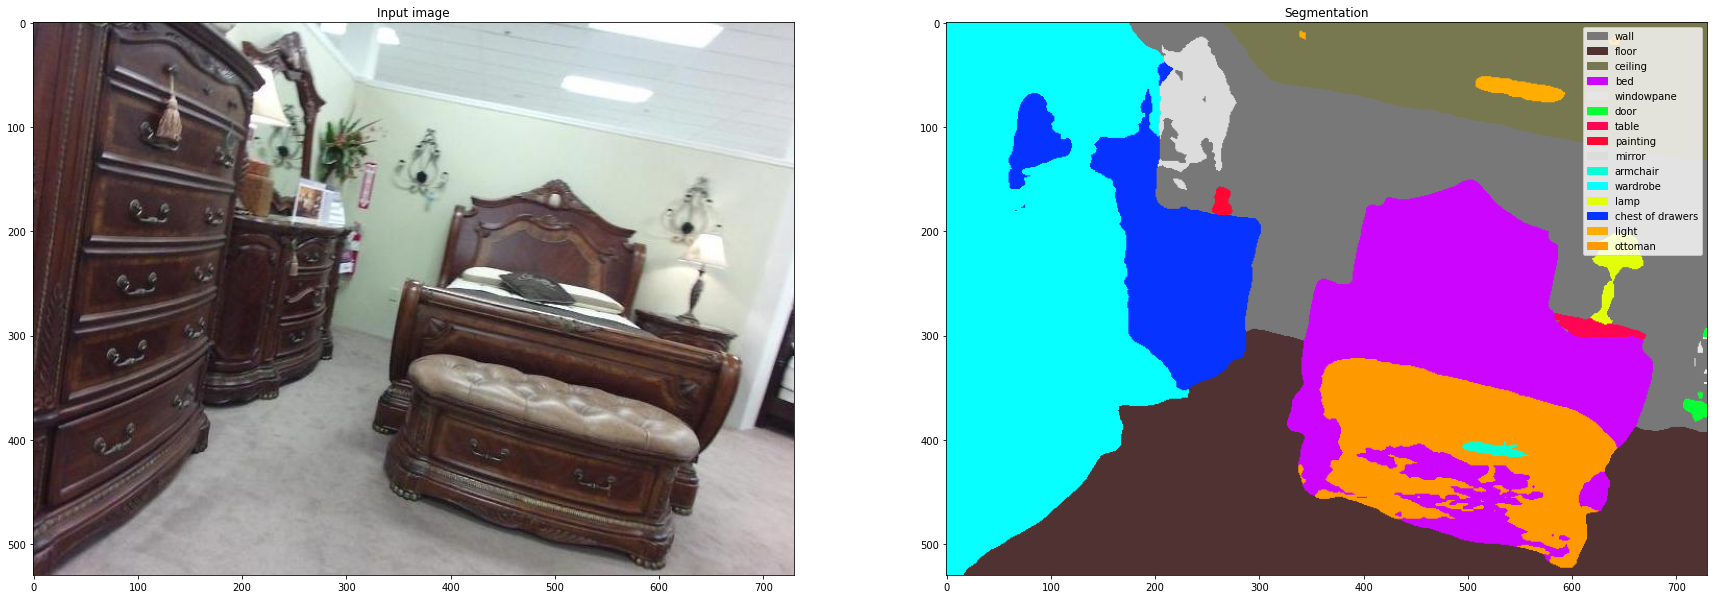

In [104]:
visualize_seg_output(image, outputs)

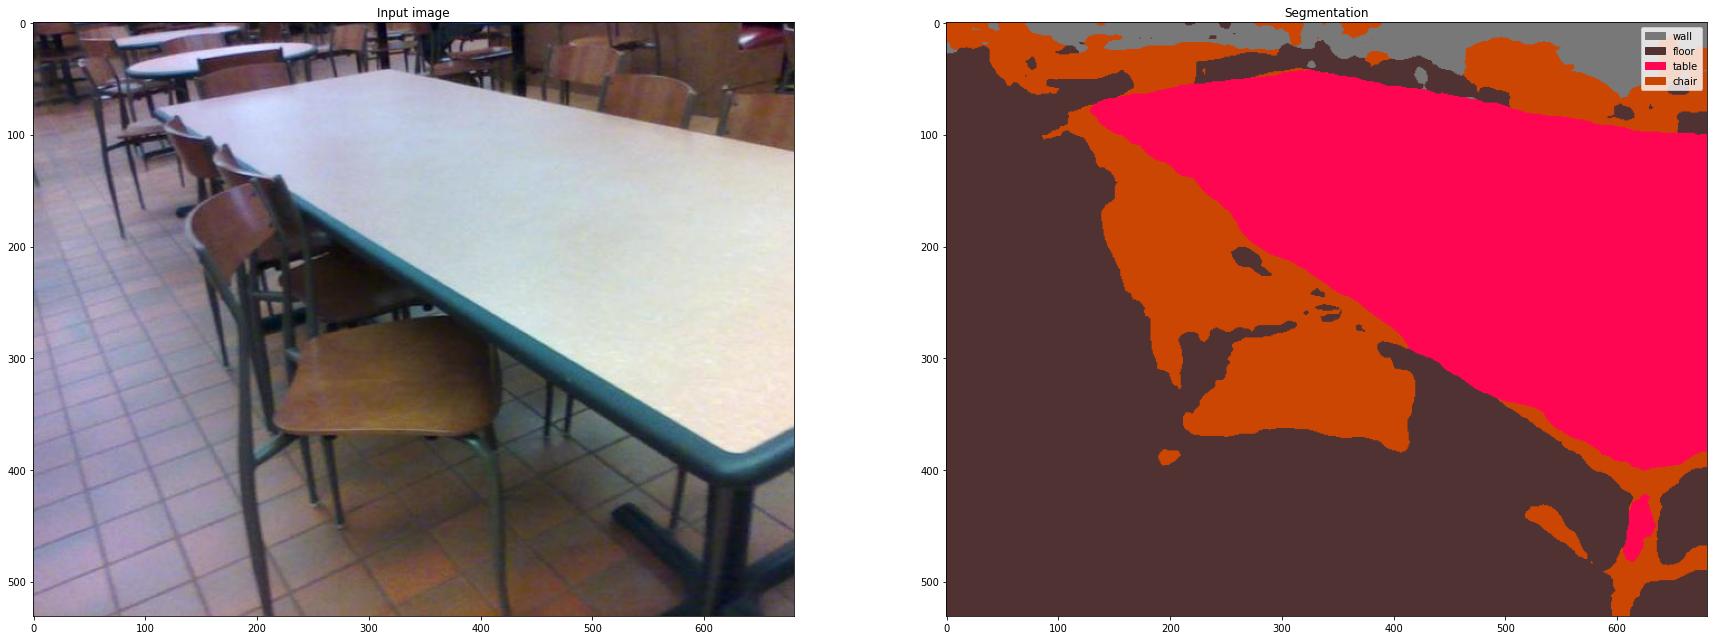